# 在COBRApy动态通量平衡分析(dFBA)

下面的笔记本展示了一个使用COBRApy和[scipy.integrate.solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html). 实现dFBA的简单但缓慢的示例。本手册展示了一个静态优化方法(SOA)实现，不应将其视为已准备就绪的产品。该模型只考虑了基本的Michaelis-Menten对葡萄糖的限制生长。

In [2]:
import numpy as np
from tqdm import tqdm

from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
%matplotlib inline

创建或加载一个网格模型。在这里，我们使用“教科书”大肠杆菌核心模型。

In [3]:
import cobra
from cobra.io import load_model
model = load_model('textbook')

## 建立动态系统

动态通量平衡分析将细胞外浓度的动态系统与伪稳态代谢模型耦合在一起。在本手册中，我们定义了`add_dynamic_bounds(model, y)`函数，即将外部代谢物浓度转换为代谢模型中边界通量的边界

In [4]:
def add_dynamic_bounds(model, y):
    """使用外部浓度来结合葡萄糖的摄取通量."""
    biomass, glucose = y  # expand the boundary species
    glucose_max_import = -10 * glucose / (5 + glucose)
    model.reactions.EX_glc__D_e.lower_bound = glucose_max_import
    

def dynamic_system(t, y):
    """计算外部物质的时间导数."""

    biomass, glucose = y  # 扩展边界物种
    
    # 计算给定外部浓度下的特定交换通量。
    with model:
        add_dynamic_bounds(model, y)
        
        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)
        lex_constraints = cobra.util.add_lexicographic_constraints(
            model, ['Biomass_Ecoli_core', 'EX_glc__D_e'], ['max', 'max'])
    
    # 由于计算出的通量是具体速率，所以我们需要将它们乘以生物量浓度，以此来得到总体的交换速率。
    fluxes = lex_constraints.values
    fluxes *= biomass
    
    # 这个程序实现起来并不高效，因此我通过显示进度条来展示当前的模拟时间进程。
    
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description('t = {:.3f}'.format(t))
        
    return fluxes

dynamic_system.pbar = None


def infeasible_event(t, y):
    """
    Determine solution feasibility.

    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function re-solves the LP to determine whether or not the solution is feasible
    (and if not, how far it is from feasibility). When the sign of this function changes
    from -epsilon to positive, we know the solution is no longer feasible.
    
    """
    
    with model:
        
        add_dynamic_bounds(model, y)
        
        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)
        
    return feasibility - infeasible_event.epsilon

infeasible_event.epsilon = 1E-6
infeasible_event.direction = 1
infeasible_event.terminal = True

## 运行动态FBA模拟

In [5]:
ts = np.linspace(0, 15, 100)  # 所需的积分分辨率和间隔
y0 = [0.1, 10]

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
        fun=dynamic_system,
        events=[infeasible_event],
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        rtol=1e-6,
        atol=1e-8,
        method='BDF'
    )

t = 5.804: : 185it [00:33,  5.50it/s]


因为培养物的葡萄糖耗尽，模拟提前终止。这个“细胞死亡”的确切时间记录在`sol.t_events`。

In [6]:
sol

  message: A termination event occurred.
  success: True
   status: 1
        t: [ 0.000e+00  1.515e-01 ...  5.606e+00  5.758e+00]
        y: [[ 1.000e-01  1.090e-01 ...  8.715e-01  8.727e-01]
            [ 1.000e+01  9.895e+00 ...  3.476e-01  2.710e-01]]
      sol: None
 t_events: [array([ 5.802e+00])]
 y_events: [array([[ 8.728e-01,  2.518e-01]])]
     nfev: 179
     njev: 2
      nlu: 14

## 绘制生物量和葡萄糖的时间表

Text(0, 0.5, 'Glucose')

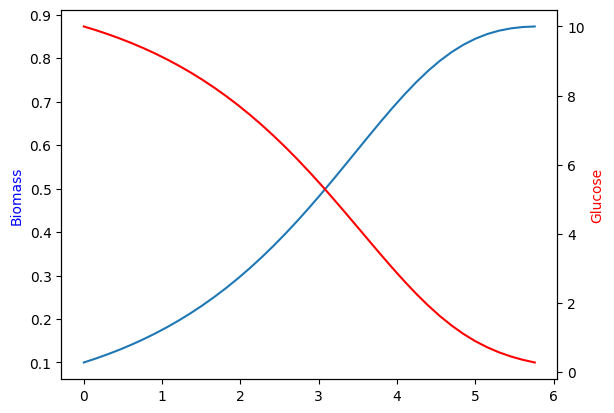

In [7]:
ax = plt.subplot(111)
ax.plot(sol.t, sol.y.T[:, 0])
ax2 = plt.twinx(ax)
ax2.plot(sol.t, sol.y.T[:, 1], color='r')

ax.set_ylabel('Biomass', color='b')
ax2.set_ylabel('Glucose', color='r')